# Setup

In [144]:
# handle math and data
import numpy as np
import pandas as pd
import time

# to plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# handle files
import os
import sys
import joblib

# constants
SEED = 69

# save path
MODEL_PATH = os.path.join(".", "_tf_models", "9_mlp")
os.makedirs(MODEL_PATH, exist_ok=True)
INITIAL_MODEL_PATH = os.path.join(MODEL_PATH, "model_init.h5")
CHECKPOINT_MODEL_PATH = os.path.join(MODEL_PATH, "model_cp_{epoch:02d}.h5")
BEST_MODEL_PATH = os.path.join(MODEL_PATH, "model_best.h5")

# tensorboard
ROOT_LOGDIR = os.path.join(".", "_tf_logs", "9_mlp")
os.makedirs(ROOT_LOGDIR, exist_ok=True)    

# Overview

Our goal is to train an accurate deep MLP on the MNIST dataset.<br>
We need to do the following:
1. Get the mnist dataset and understand it, then split into train, val, test
2. Process the dataset (like scaling it)
3. Attempt an initial deep MLP using Keras API and only 10 epochs
    - 10 hidden layers, 100 artificial neurons per layer, ReLU activation
    - 1 output layer, 10 output neurons, softmax activation
4. Find optimal learning rate
    - grow learning rate exponentially with epochs
    - plot loss over learning rate and find point of spike in loss
    - set learning rate to that point / 2
5. Using optimal learning rate, train model using early stopping
    - use three callbacks: save best model, early stopping, tensorboard
    - visualize training with tensorboard
6. Evaluate best model (hopefully) after early stopping on test set
    - goal is above 98% accuracy

# Get MNIST Dataset

In [2]:
from tensorflow import keras

In [4]:
mnist = keras.datasets.mnist.load_data()

Here is the **[documenation](https://keras.io/api/datasets/mnist/#load_data-function)** for `mnist.load_data()`.

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = mnist

X_train_full.shape, X_train_full.dtype

((60000, 28, 28), dtype('uint8'))

In [11]:
some_digit = X_train_full[0]

some_digit.mean(), some_digit.min(), some_digit.max()

(35.108418367346935, 0, 255)

We will need to scale this by 255.

## Split and Scale

- Split `X_train_full` and `y_train_full` into training and validation datasets
- Scale all X datasets by 255 so they are 0 to 1

In [17]:
def get_class_ratios(y):
    return (np.unique(y, return_counts=True)[1] / y.shape[0]).round(2)

get_class_ratios(y_train_full)

array([0.1 , 0.11, 0.1 , 0.1 , 0.1 , 0.09, 0.1 , 0.1 , 0.1 , 0.1 ])

In [18]:
get_class_ratios(y_train_full[:5000])

array([0.1 , 0.11, 0.1 , 0.1 , 0.11, 0.09, 0.1 , 0.11, 0.09, 0.1 ])

Ok the dataset is already shuffled pretty evenly, so no need for stratified splitting.

In [19]:
X_test.shape

(10000, 28, 28)

In [22]:
val_size = 10000
X_train, X_val = X_train_full[val_size:], X_train_full[:val_size]
y_train, y_val = y_train_full[val_size:], y_train_full[:val_size]

X_train.shape, y_train.shape

((50000, 28, 28), (50000,))

Now let's scale.

In [23]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [24]:
y_train.dtype

dtype('uint8')

## Visualize Digits

Now let's make sure we can visualize each digit (already 28 by 28).

In [25]:
def plot_digit(digit):    
    plt.figure(figsize=(4,4))
    plt.imshow(digit, cmap="binary")
    plt.axis("off")
    plt.show()

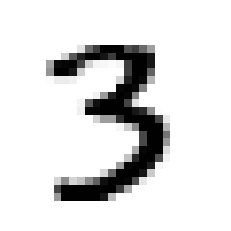

In [26]:
plot_digit(X_train[0])

In [39]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    instances = instances.reshape(instances.shape[0], size**2)
    
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 64x64 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.figure(figsize=(8,8))
    plt.imshow(big_image, cmap="binary", **options)
    plt.axis("off")

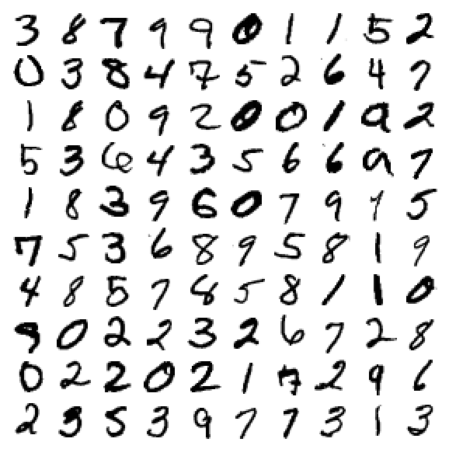

In [40]:
plot_digits(X_train[:100])

# Initial Model

Let's first train a deep model and run it for only 10 epochs, just to get an estimate of the time taken.

In [106]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

n_layers = 10
n_neurons = 100
n_outputs = 10
lr = 1e-2

model = Sequential()
model.add(Flatten(input_shape=[28, 28]))
for i in range(n_layers):
    model.add(Dense(n_neurons, activation="relu"))
model.add(Dense(n_outputs, activation="softmax"))

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=SGD(learning_rate=lr),
    metrics=["accuracy"],
)

# so we don't have to re-compile every time we want to reset
model.save(INITIAL_MODEL_PATH)

In [75]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val))

Epoch 1/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.7224 - accuracy: 0.4172 - val_loss: 0.6506 - val_accuracy: 0.8064
Epoch 2/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.3936 - accuracy: 0.8835 - val_loss: 0.2596 - val_accuracy: 0.9269
Epoch 3/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.2302 - accuracy: 0.9332 - val_loss: 0.2353 - val_accuracy: 0.9326
Epoch 4/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1740 - accuracy: 0.9495 - val_loss: 0.2798 - val_accuracy: 0.9175
Epoch 5/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1396 - accuracy: 0.9592 - val_loss: 0.1623 - val_accuracy: 0.9535
Epoch 6/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1160 - accuracy: 0.9666 - val_loss: 0.1335 - val_accuracy: 0.9620
Epoch 7/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0985 - accuracy: 0.9703 - val_loss: 0.1355 - val_accuracy:

A deeper neural net actually has less parameters than a shallower yet much wider one.

In [76]:
loss_history = pd.DataFrame(history.history)
loss_history.columns

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')

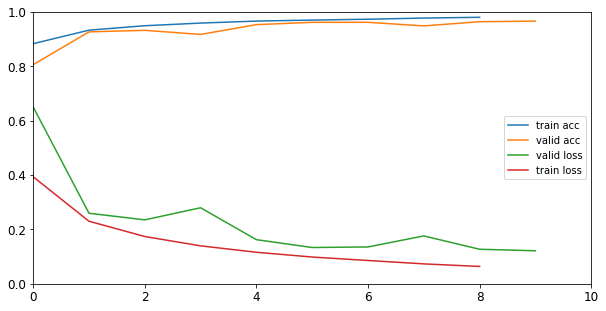

In [77]:
plt.figure(figsize=(10, 5))
plt.plot(range(-1,9), loss_history["accuracy"], label="train acc")
plt.plot(range(10), loss_history["val_accuracy"], label="valid acc")
plt.plot(range(10), loss_history["val_loss"], label="valid loss")
plt.plot(range(-1,9), loss_history["loss"], label="train loss")
plt.legend(loc='center right')
plt.gca().set_xlim(0, 10)
plt.gca().set_ylim(0, 1)
plt.show()

This model seems quite good actually, a training accuracy of 0.9812 and validation accuracy of 0.9712 after only 10 epochs, and training was quite fast.

But, we've got to try out some techniques.

# Optimal Learning Rate

To get the optimal learning rate, we need to do the following:
- Create scheduler function for `LearningRateScheduler` callback class
- Initialize model weights
- Create `LearningRateScheduler` callback
- Use `LearningRateScheduler` callback in `model.fit(callbacks=[callback])`

The **[documentation](https://keras.io/api/callbacks/learning_rate_scheduler/)** for LearningRateScheduler.

In [152]:
# should multiply learning rate by 3 every epoch
def scheduler(epochs, lr):
    if epochs > 0:
        return lr * 3
    else:
        return lr

`LearninRateScheduler` prints lr too, so no need to make a custom callback for that.

Create function for initializing model.

In [153]:
def return_model(n_layers=10, n_neurons=100, n_outputs=10):
    model = Sequential()
    model.add(Flatten(input_shape=[28, 28]))
    for i in range(n_layers):
        model.add(Dense(n_neurons, activation="relu"))
    model.add(Dense(n_outputs, activation="softmax"))

    return model

In [174]:
# re-init model
model = return_model(n_layers=4, n_neurons=300)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=SGD(learning_rate=1e-4),
    metrics=["accuracy"],
)

lr_scheduler_cb = keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=[lr_scheduler_cb])

Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 2.2944 - accuracy: 0.1637 - val_loss: 2.2725 - val_accuracy: 0.2004 - lr: 1.0000e-04
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 2.2134 - accuracy: 0.3417 - val_loss: 2.1421 - val_accuracy: 0.4745 - lr: 3.0000e-04
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.7942 - accuracy: 0.6409 - val_loss: 1.2977 - val_accuracy: 0.7447 - lr: 9.0000e-04
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.6715 - accuracy: 0.8348 - val_loss: 0.4240 - val_accuracy: 0.8851 - lr: 0.0027
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3359 - accuracy: 0.9032 - val_loss: 0.2786 - val_accuracy: 0.9189 - lr: 0.0081
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2270 - accuracy: 0.9328 - val_loss: 0.2044 - val_accuracy: 0.9362 - lr: 0.0243
Epoch 7/10
1563/1563 [========================

In [175]:
df_history = pd.DataFrame(history.history)
df_history[:9]

,loss,accuracy,val_loss,val_accuracy,lr
0,2.294383,0.16366,2.272476,0.2004,0.0001
1,2.213392,0.34172,2.142136,0.4745,0.0003
2,1.794184,0.64092,1.297667,0.7447,0.0009
3,0.671489,0.83484,0.424037,0.8851,0.0027
4,0.335942,0.90322,0.278602,0.9189,0.0081
5,0.226969,0.93276,0.204352,0.9362,0.0243
6,0.163454,0.95082,0.126816,0.9617,0.0729
7,0.176159,0.94700,0.141763,0.9577,0.2187
8,NaN,0.10148,NaN,0.1001,0.6561


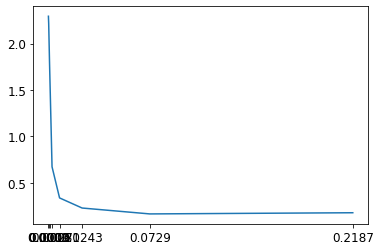

In [176]:
plt.plot("lr", "loss", data=df_history[:8])
plt.xticks(ticks=df_history["lr"][:8])
plt.show()

It seems that at `lr=0.0729` we had a massive spike in loss before loss became `NaN`.

So, the optimal learning rate should be about `0.036`.

# Train Model w/ Early Stopping

We want to train the best deep MLP without overfitting, so we need to do the following:
- Create **[ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/)** callback
- Create **[EarlyStopping](https://keras.io/api/callbacks/early_stopping/)** callback
- Create **[TensorBoard](https://keras.io/api/callbacks/tensorboard/)** callback
    - Create a new directory named using date-time every run
- Fit model with large amount of epochs
- Visualize tensorboard

In [157]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(CHECKPOINT_MODEL_PATH, save_best_only=True)

In [158]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [159]:
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(ROOT_LOGDIR, run_id)

The below code will do this every epoch:
- Save best model in format *"model_cp_{epoch:02d}.h5"*
- Stop model if loss hasn't improved in 10 epochs
- Update event logs in `run_logdir`

In [177]:
# Deep model and we have early stopping
model = return_model(n_layers=4, n_neurons=300)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=SGD(learning_rate=0.036),
    metrics=["accuracy"],
)

In [178]:
run_logdir = get_run_logdir()
print("TensorBoard event logs for this run:", run_logdir)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=run_logdir)

history = model.fit(X_train, y_train, epochs=1000,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

TensorBoard event logs for this run: ./_tf_logs/9_mlp/run_2022_06_21-11_31_26
Epoch 1/1000
1563/1563 [==============================] - 6s 3ms/step - loss: 0.3951 - accuracy: 0.8858 - val_loss: 0.1897 - val_accuracy: 0.9439
Epoch 2/1000
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1496 - accuracy: 0.9552 - val_loss: 0.1367 - val_accuracy: 0.9601
Epoch 3/1000
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1021 - accuracy: 0.9691 - val_loss: 0.1262 - val_accuracy: 0.9620
Epoch 4/1000
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0765 - accuracy: 0.9757 - val_loss: 0.0893 - val_accuracy: 0.9742
Epoch 5/1000
1563/1563 [==============================] - 5s 4ms/step - loss: 0.0585 - accuracy: 0.9816 - val_loss: 0.1282 - val_accuracy: 0.9634
Epoch 6/1000
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0453 - accuracy: 0.9860 - val_loss: 0.0913 - val_accuracy: 0.9739
Epoch 7/1000
1563/1563 [======================

In [181]:
model.save(BEST_MODEL_PATH)

The accuracy is 100% on training and about 98% on validation, let's evaluate it on the test set.

# Evaluate on Test Set

In [182]:
model = keras.models.load_model(BEST_MODEL_PATH)

In [183]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1121 - accuracy: 0.9741


[0.1121031865477562, 0.9740999937057495]

I couldn't break through the 98% accuracy mark...

Perhaps fine-tuning the number of layers and neurons would be a good decision here.

# What I Did Wrong

With comparison to Gerion's solution, it seems I did a couple things wrong:
- First, my learning rate optimizer had a factor of x3 at every epoch
    - This is not only too much of a jump, but also too long of an interval
    - Gerion used a smaller factor of 1.005, but at every batch
        - This allows for a much finer graph (since intervals are smaller) and there's a much smaller chance of accidentally skipping the optimal learning rate due to too high of a factor or too big of an interval
- Second, my neural network had too many layers and neurons
    - Gerion's had just two hidden layers of 300 and then 100 neuronsj
        - Although I didn't overfit the dataset, this is a reason why my test set accuracy was 97.4% instead of 98%
            - But, perhaps my model will generalize better to new instances - who knows